## Welcome

This is material for the **Regression Discontinuity** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)


In [197]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [198]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    full_path = "https://raw.github.com/scunning1975/mixtape/master/" + file
    
    return pd.read_stata(full_path)
    

## RDD Simulation

Generate a simple Regression Discontinuity, before and after the treatment is given. 

In [199]:
dat = pd.DataFrame({'x': np.random.normal(50, 25, 1000)})
dat.loc[dat.x<0, 'x'] = 0
dat = dat[dat.x<100]
dat['D'] = 0
dat.loc[dat.x>50, 'D'] = 1
dat['y1'] = 25 + 0*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])
dat['y2'] = 25 + 40*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])

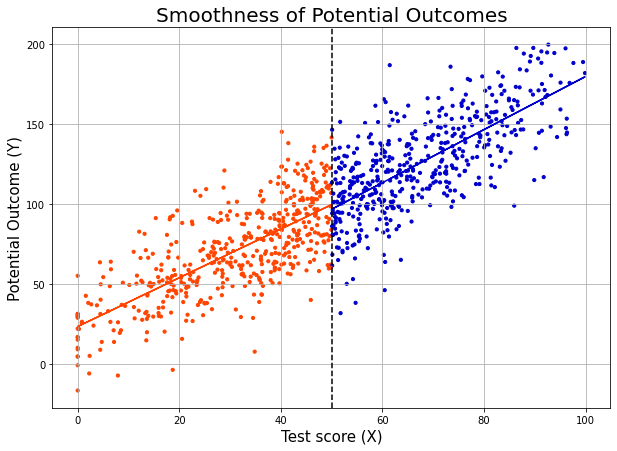

In [200]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 7))

# Add scatterplot
colors = {0: 'orangered', 1: 'mediumblue'}
plt.scatter(dat.x, dat.y1, c = dat['D'].map(colors), s = 10)

# Create line-of-best fit and add to plot
threshold = 50

m1, b1 = np.polyfit(dat.x[dat.x < threshold], dat.y1[dat.x < threshold], deg = 1)
ax.plot(dat.x[dat.x < threshold], m1*dat.x[dat.x < threshold] + b1, color = 'orangered')

m2, b2 = np.polyfit(dat.x[dat.x > threshold], dat.y1[dat.x > threshold], deg = 1)
ax.plot(dat.x[dat.x > threshold], m2*dat.x[dat.x > threshold] + b2, color = 'mediumblue')

# Demarcate test scores
ax.axvline(x = 50, color = 'black', ls = '--')

# Customize the plot by adding title and gridlines
ax.set_title('Smoothness of Potential Outcomes', size = 20)
ax.set_xlabel('Test score (X)', size = 15)
ax.set_ylabel('Potential Outcome (Y)', size = 15)
ax.grid()

# Show plot
plt.show()

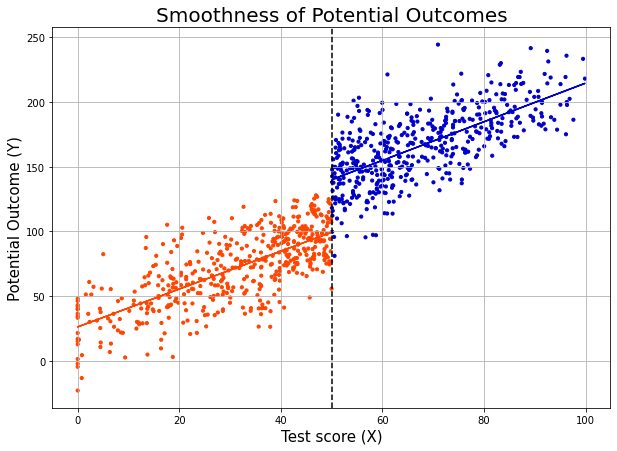

In [201]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 7))

# Add scatterplot
colors = {0: 'orangered', 1: 'mediumblue'}
plt.scatter(dat.x, dat.y2, c = dat['D'].map(colors), s = 10)

# Create line-of-best fit and add to plot
threshold = 50

m1, b1 = np.polyfit(dat.x[dat.x < threshold], dat.y2[dat.x < threshold], deg = 1)
ax.plot(dat.x[dat.x < threshold], m1*dat.x[dat.x < threshold] + b1, color = 'orangered')

m2, b2 = np.polyfit(dat.x[dat.x > threshold], dat.y2[dat.x > threshold], deg = 1)
ax.plot(dat.x[dat.x > threshold], m2*dat.x[dat.x > threshold] + b2, color = 'mediumblue')

# Demarcate test scores
ax.axvline(x = 50, color = 'black', ls = '--')

# Customize the plot by adding title and gridlines
ax.set_title('Smoothness of Potential Outcomes', size = 20)
ax.set_xlabel('Test score (X)', size = 15)
ax.set_ylabel('Potential Outcome (Y)', size = 15)
ax.grid()

# Show plot
plt.show()

In [202]:
dat = pd.DataFrame({'x': np.random.normal(100, 50, 1000)})
dat.loc[dat.x<0, 'x'] = 0
dat['x2'] = dat['x']**2
dat['x3'] = dat['x']**3
dat['D'] = 0
dat.loc[dat.x > 140, 'D'] = 1

dat['y3'] = 10000 + 0*dat.D - 100 * dat.x + dat.x2 + np.random.normal(0, 1000, 1000)
dat = dat[dat.x < 280]

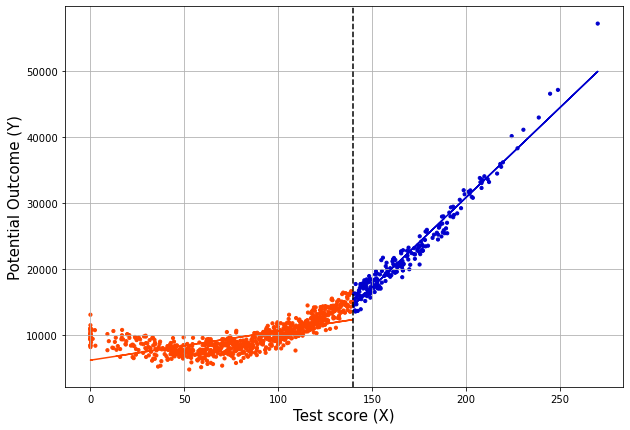

In [203]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 7))

# Add scatterplot
colors = {0: 'orangered', 1: 'mediumblue'}
plt.scatter(dat.x, dat.y3, c = dat['D'].map(colors), s = 10)

# Create line-of-best fit and add to plot
threshold = 140

m1, b1 = np.polyfit(dat.x[dat.x < threshold], dat.y3[dat.x < threshold], deg = 1)
ax.plot(dat.x[dat.x < threshold], m1*dat.x[dat.x < threshold] + b1, color = 'orangered')

m2, b2 = np.polyfit(dat.x[dat.x > threshold], dat.y3[dat.x > threshold], deg = 1)
ax.plot(dat.x[dat.x > threshold], m2*dat.x[dat.x > threshold] + b2, color = 'mediumblue')

# Demarcate test scores
ax.axvline(x = threshold, color = 'black', ls = '--')

# Customize the plot by adding title and gridlines
ax.set_xlabel('Test score (X)', size = 15)
ax.set_ylabel('Potential Outcome (Y)', size = 15)
ax.grid()

# Show plot
plt.show()

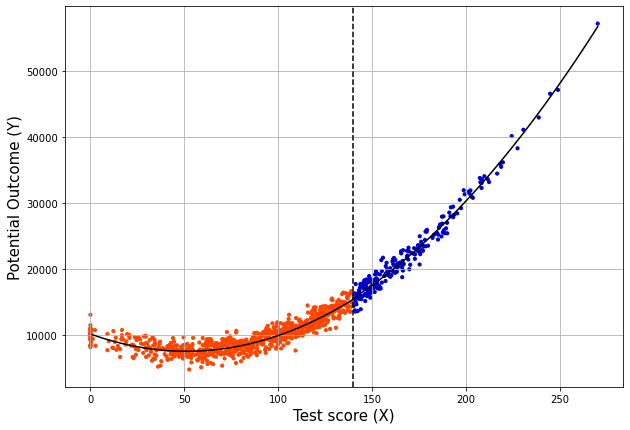

In [204]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 7))

# Add scatterplot
colors = {0: 'orangered', 1: 'mediumblue'}
plt.scatter(dat.x, dat.y3, c = dat['D'].map(colors), s = 10)

# Create line-of-best fit and add to plot
threshold = 140

polyline_below = np.linspace(1, threshold)
polyline_above = np.linspace(threshold, max(dat.x))

model_below = np.poly1d(np.polyfit(dat.x[dat.x < threshold], dat.y3[dat.x < threshold], deg = 2))
ax.plot(polyline_below, model_below(polyline_below), color = 'black')

model_above = np.poly1d(np.polyfit(dat.x[dat.x > threshold], dat.y3[dat.x > threshold], deg = 2))
ax.plot(polyline_above, model_above(polyline_above), color = 'black')

# Demarcate test scores
ax.axvline(x = threshold, color = 'black', ls = '--')

# Customize the plot by adding title and gridlines
ax.set_xlabel('Test score (X)', size = 15)
ax.set_ylabel('Potential Outcome (Y)', size = 15)
ax.grid()

# Show plot
plt.show()

#### Questions
- If you estimated the treatment effect using the linear model, would your treatment effect estimate be near the true treatment effect? 



In [205]:
np.random.seed(12282020)

# Fully interacted regression
all_columns = "+".join(dat.columns.difference(["D", 'y3']))
formula = 'y3 ~ D * ({})'.format(all_columns)

regression = sm.OLS.from_formula(formula, data = dat).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     5810.
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:56:54   Log-Likelihood:                -8308.5
No. Observations:                1000   AIC:                         1.663e+04
Df Residuals:                     992   BIC:                         1.667e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.013e+04    156.480     64.733      0.0

#### Question
- What did you estimate as the treatment effect using a third order polynomial of the running variable? Is it statistically significantly different from zero?
- Does the estimated treatment effect seem correct from the graph?

## The Close Election Design

Lets load the data from Lee et. al. (2004):

In [185]:
def lm_robust(formula, data):
    #regression = sm.OLS.from_formula(formula, data = data).fit(cov_type = "HC3")
    regression = sm.OLS.from_formula(formula, data = data).fit(cov_type = "cluster", cov_kwds = {"groups":data['id']})
    return regression

In [164]:
lmb_data = read_data("lmb-data.dta")

In [162]:
lmb_data

,state,district,incmbncy,demvote,repvote,year,congress,occupanc,name,eq_Dwhip,...,lagged,_merge,democrat,lagdemocrat,score,lagscore,id,id2,demvoteshare_c,demvoteshare_sq
0,01: Connecticut,1,-1: REPUBLICAN,127802.0,103294.0,1948.0,81.0,0.0,"RIBICOFF,",0.752336,...,14.760000,3,1.0,0.0,64.339996,14.760000,3.0,1.0,0.053026,0.002812
1,01: Connecticut,1,-1: REPUBLICAN,127802.0,103294.0,1948.0,81.0,0.0,"RIBICOFF,",0.752336,...,9.520000,3,1.0,0.0,60.279999,9.520000,4.0,1.0,0.053026,0.002812
2,01: Connecticut,1,1: DEMOCRAT,134258.0,96251.0,1950.0,82.0,0.0,"RIBICOFF,",0.770270,...,64.339996,3,1.0,1.0,57.060001,64.339996,5.0,1.0,0.082441,0.006797
3,01: Connecticut,1,1: DEMOCRAT,134258.0,96251.0,1950.0,82.0,0.0,"RIBICOFF,",0.770270,...,60.279999,3,1.0,1.0,73.830002,60.279999,6.0,1.0,0.082441,0.006797
4,01: Connecticut,1,1: DEMOCRAT,148935.0,112526.0,1954.0,84.0,0.0,DODD,0.730769,...,56.220001,3,1.0,1.0,42.959999,56.220001,7.0,1.0,0.069626,0.004848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13583,82: Hawaii,2,1: DEMOCRAT,112377.0,20000.0,1984.0,99.0,0.0,"AKAKA, D",0.903061,...,80.650002,3,1.0,1.0,65.660004,80.650002,17123.0,505.0,0.348916,0.121743
13584,82: Hawaii,2,1: DEMOCRAT,123830.0,35371.0,1986.0,100.0,0.0,"AKAKA, D",0.953293,...,88.489998,3,1.0,1.0,78.589996,88.489998,17124.0,505.0,0.277822,0.077185
13585,82: Hawaii,2,1: DEMOCRAT,123830.0,35371.0,1986.0,100.0,0.0,"AKAKA, D",0.953293,...,65.660004,3,1.0,1.0,58.529999,65.660004,17125.0,505.0,0.277822,0.077185
13586,82: Hawaii,2,1: DEMOCRAT,144802.0,0.0,1988.0,101.0,0.0,"AKAKA, DANI",0.940048,...,78.589996,3,1.0,1.0,80.459999,78.589996,17126.0,505.0,0.500000,0.250000


In [182]:
lmb_data['demvoteshare_c'] = lmb_data['demvoteshare'] - 0.5
lmb_subset = lmb_data[lmb_data.lagdemvoteshare.between(.48, .52)]

In [186]:
lm_1 = lm_robust('score ~ lagdemocrat', data = lmb_subset)
lm_2 = lm_robust('score ~ democrat', data = lmb_subset)
lm_3 = lm_robust('democrat ~ lagdemocrat', data = lmb_subset)
print("Original results based on ADA Scores -- Close Elections Sample")
models = [lm_1, lm_2, lm_3]
model_names = ['ADA, t + 1', 'ADA, t', 'DEM, t + 1']
summary_col(models, float_format='%0.2f', model_names = model_names, regressor_order = ('lagdemocrat', 'democrat'))

Original results based on ADA Scores -- Close Elections Sample


,"ADA, t + 1","ADA, t","DEM, t + 1"
lagdemocrat,21.28,,0.48
,(1.95),,(0.03)
democrat,,47.71,
,,(1.36),
Intercept,31.20,18.75,0.24
,(1.33),(0.84),(0.02)
R-squared,0.12,0.58,0.23
R-squared Adj.,0.11,0.58,0.23


#### using all data (note data used is lmb_data, not lmb_subset)

In [187]:
lm_1 = lm_robust('score ~ lagdemocrat', data = lmb_data)
lm_2 = lm_robust('score ~ democrat', data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat', data = lmb_data)
print("Original results based on ADA Scores -- Full Sample")
models = [lm_1, lm_2, lm_3]
model_names = ['ADA, t + 1', 'ADA, t', 'DEM, t + 1']
summary_col(models, float_format='%0.2f', model_names = model_names, regressor_order = ('lagdemocrat', 'democrat'))

Original results based on ADA Scores -- Full Sample


,"ADA, t + 1","ADA, t","DEM, t + 1"
lagdemocrat,31.51,,0.82
,(0.48),,(0.01)
democrat,,40.76,
,,(0.42),
Intercept,23.54,17.58,0.12
,(0.34),(0.26),(0.00)
R-squared,0.23,0.38,0.68
R-squared Adj.,0.23,0.38,0.68


In [188]:
# drop missing values
lmb_data = lmb_data[~pd.isnull(lmb_data.demvoteshare_c)]

In [189]:
lm_1 = lm_robust('score ~ lagdemocrat + demvoteshare_c', data = lmb_data)
lm_2 = lm_robust('score ~ democrat + demvoteshare_c', data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat + demvoteshare_c', data = lmb_data)
print("Results based on ADA Scores -- Full Sample")
models = [lm_1, lm_2, lm_3]
model_names = ['ADA, t + 1', 'ADA, t', 'DEM, t + 1']
summary_col(models, float_format='%0.2f', model_names = model_names, regressor_order = ('lagdemocrat', 'democrat', 'demvoteshare_c'))

Results based on ADA Scores -- Full Sample


,"ADA, t + 1","ADA, t","DEM, t + 1"
lagdemocrat,33.45,,0.55
,(0.85),,(0.01)
democrat,,58.50,
,,(0.66),
demvoteshare_c,-5.63,-48.94,0.77
,(1.90),(1.64),(0.02)
Intercept,22.88,11.03,0.21
,(0.44),(0.34),(0.01)
R-squared,0.23,0.42,0.74
R-squared Adj.,0.23,0.42,0.74


In [190]:
lm_1 = lm_robust('score ~ lagdemocrat*demvoteshare_c', data = lmb_data)
lm_2 = lm_robust('score ~ democrat*demvoteshare_c', data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat*demvoteshare_c', data = lmb_data)

print("Original results based on ADA Scores -- Full Sample with linear interactions")

models = [lm_1, lm_2, lm_3]
model_names = ['ADA, t + 1', 'ADA, t', 'DEM, t + 1']
summary_col(models, float_format='%0.2f', model_names = model_names, regressor_order = ('lagdemocrat', 'democrat'))

Original results based on ADA Scores -- Full Sample with linear interactions


,"ADA, t + 1","ADA, t","DEM, t + 1"
lagdemocrat,30.51,,0.53
,(0.82),,(0.01)
democrat,,55.43,
,,(0.64),
lagdemocrat:demvoteshare_c,-96.47,,-0.85
,(3.85),,(0.05)
democrat:demvoteshare_c,,-55.15,
,,(3.22),
demvoteshare_c,66.04,-5.68,1.40
,(3.16),(2.61),(0.04)


In [192]:
lmb_data['demvoteshare_sq'] = lmb_data['demvoteshare_c']**2

<ipython-input-192-668d3e6ccb56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [193]:
lmb_data

,state,district,incmbncy,demvote,repvote,year,congress,occupanc,name,eq_Dwhip,...,lagged,_merge,democrat,lagdemocrat,score,lagscore,id,id2,demvoteshare_c,demvoteshare_sq
0,01: Connecticut,1,-1: REPUBLICAN,127802.0,103294.0,1948.0,81.0,0.0,"RIBICOFF,",0.752336,...,14.760000,3,1.0,0.0,64.339996,14.760000,3.0,1.0,0.053026,0.002812
1,01: Connecticut,1,-1: REPUBLICAN,127802.0,103294.0,1948.0,81.0,0.0,"RIBICOFF,",0.752336,...,9.520000,3,1.0,0.0,60.279999,9.520000,4.0,1.0,0.053026,0.002812
2,01: Connecticut,1,1: DEMOCRAT,134258.0,96251.0,1950.0,82.0,0.0,"RIBICOFF,",0.770270,...,64.339996,3,1.0,1.0,57.060001,64.339996,5.0,1.0,0.082441,0.006797
3,01: Connecticut,1,1: DEMOCRAT,134258.0,96251.0,1950.0,82.0,0.0,"RIBICOFF,",0.770270,...,60.279999,3,1.0,1.0,73.830002,60.279999,6.0,1.0,0.082441,0.006797
4,01: Connecticut,1,1: DEMOCRAT,148935.0,112526.0,1954.0,84.0,0.0,DODD,0.730769,...,56.220001,3,1.0,1.0,42.959999,56.220001,7.0,1.0,0.069626,0.004848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13583,82: Hawaii,2,1: DEMOCRAT,112377.0,20000.0,1984.0,99.0,0.0,"AKAKA, D",0.903061,...,80.650002,3,1.0,1.0,65.660004,80.650002,17123.0,505.0,0.348916,0.121743
13584,82: Hawaii,2,1: DEMOCRAT,123830.0,35371.0,1986.0,100.0,0.0,"AKAKA, D",0.953293,...,88.489998,3,1.0,1.0,78.589996,88.489998,17124.0,505.0,0.277822,0.077185
13585,82: Hawaii,2,1: DEMOCRAT,123830.0,35371.0,1986.0,100.0,0.0,"AKAKA, D",0.953293,...,65.660004,3,1.0,1.0,58.529999,65.660004,17125.0,505.0,0.277822,0.077185
13586,82: Hawaii,2,1: DEMOCRAT,144802.0,0.0,1988.0,101.0,0.0,"AKAKA, DANI",0.940048,...,78.589996,3,1.0,1.0,80.459999,78.589996,17126.0,505.0,0.500000,0.250000


In [194]:
lm_1 = lm_robust('score ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_data)
lm_2 = lm_robust('score ~ democrat*demvoteshare_c + democrat*demvoteshare_sq', 
                 data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_data)
print("Original results based on ADA Scores -- Full Sample with linear and quadratic interactions")
models = [lm_1, lm_2, lm_3]
model_names = ['ADA, t + 1', 'ADA, t', 'DEM, t + 1']
summary_col(models, float_format='%0.2f', model_names = model_names, regressor_order = ('lagdemocrat', 'democrat'))

Original results based on ADA Scores -- Full Sample with linear and quadratic interactions


,"ADA, t + 1","ADA, t","DEM, t + 1"
lagdemocrat,13.03,,0.32
,(1.27),,(0.02)
democrat,,44.40,
,,(0.91),
lagdemocrat:demvoteshare_c,57.05,,0.09
,(15.15),,(0.24)
democrat:demvoteshare_c,,111.90,
,,(9.78),
lagdemocrat:demvoteshare_sq,-641.85,,-8.80
,(30.80),,(0.51)


In [195]:
lmb_subset = lmb_data[lmb_data.demvoteshare.between(.45, .55)]

In [206]:
lm_1 = lm_robust('score ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_subset)
lm_2 = lm_robust('score ~ democrat*demvoteshare_c + democrat*demvoteshare_sq', 
                 data = lmb_subset)
lm_3 = lm_robust('democrat ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_subset)

print("Results based on ADA Scores -- Close Sample with linear and quadratic interactions")

models = [lm_1, lm_2, lm_3]
model_names = ['ADA, t + 1', 'ADA, t', 'DEM, t + 1']
summary_col(models, float_format='%0.2f', model_names = model_names, regressor_order = (['lagdemocrat', 'democrat']))

Results based on ADA Scores -- Close Sample with linear and quadratic interactions


,"ADA, t + 1","ADA, t","DEM, t + 1"
lagdemocrat,7.35,,0.17
,(1.59),,(0.02)
democrat,,45.19,
,,(2.68),
lagdemocrat:demvoteshare_c,-156.88,,0.12
,(35.69),,(0.36)
democrat:demvoteshare_c,,-688.34,
,,(247.49),
lagdemocrat:demvoteshare_sq,-10116.68,,-188.33
,(1433.72),,(16.32)


In [243]:
#aggregating the data
lmb_data = lmb_data[lmb_data.demvoteshare.between(.45, .55)]
categories = lmb_data.lagdemvoteshare
lmb_data['lagdemvoteshare_100'] = pd.cut(lmb_data.lagdemvoteshare, 100)

agg_lmb_data = lmb_data.groupby('lagdemvoteshare_100')['score'].mean().reset_index()
lmb_data['gg_group'] = [1 if x > 0.5 else 0 for x in lmb_data.lagdemvoteshare]
agg_lmb_data['lagdemvoteshare'] = np.arange(0.01, 1.01, .01)

In [236]:
agg_lmb_data.dropna(inplace=True)

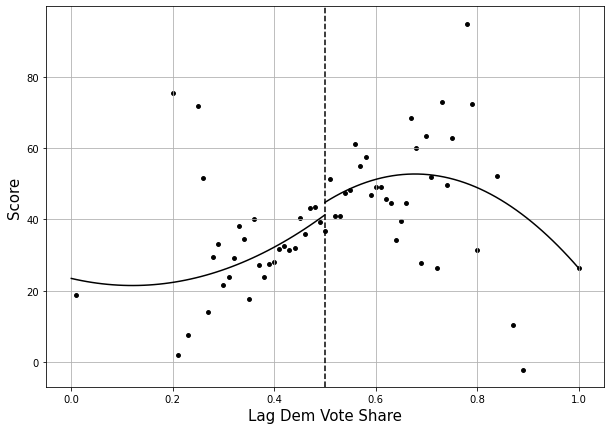

In [254]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 7))

# Add scatterplot
# colors = {0: 'orangered', 1: 'mediumblue'}
plt.scatter(agg_lmb_data.lagdemvoteshare, agg_lmb_data.score, s = 15, c = 'black')

# Create line-of-best fit and add to plot
threshold = 0.5

polyline_below = np.linspace(0, threshold)
polyline_above = np.linspace(threshold, max(lmb_data.lagdemvoteshare))

model_below = np.poly1d(np.polyfit(lmb_data.lagdemvoteshare[lmb_data.lagdemvoteshare < threshold], 
                                   lmb_data.score[lmb_data.lagdemvoteshare < threshold], deg = 2))

ax.plot(polyline_below, model_below(polyline_below), color = 'black')

model_above = np.poly1d(np.polyfit(lmb_data.lagdemvoteshare[lmb_data.lagdemvoteshare > threshold], 
                                   lmb_data.score[lmb_data.lagdemvoteshare > threshold], deg = 2))

ax.plot(polyline_above, model_above(polyline_above), color = 'black')

# Demarcate test scores
ax.axvline(x = threshold, color = 'black', ls = '--')

# Customize the plot by adding title and gridlines
ax.set_xlabel('Lag Dem Vote Share', size = 15)
ax.set_ylabel('Score', size = 15)
ax.grid()

# Show plot
plt.show()

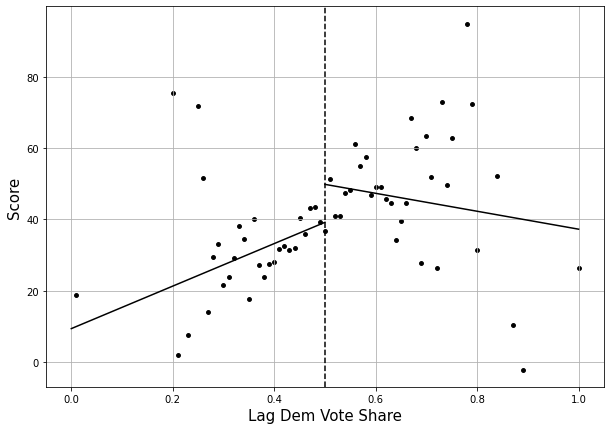

In [245]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 7))

# Add scatterplot
# colors = {0: 'orangered', 1: 'mediumblue'}
plt.scatter(agg_lmb_data.lagdemvoteshare, agg_lmb_data.score, s = 15, c = 'black')

# Create line-of-best fit and add to plot
threshold = 0.5

polyline_below = np.linspace(0, threshold)
polyline_above = np.linspace(threshold, max(lmb_data.lagdemvoteshare))

model_below = np.poly1d(np.polyfit(lmb_data.lagdemvoteshare[lmb_data.lagdemvoteshare < threshold], 
                                   lmb_data.score[lmb_data.lagdemvoteshare < threshold], deg = 1))

ax.plot(polyline_below, model_below(polyline_below), color = 'black')

model_above = np.poly1d(np.polyfit(lmb_data.lagdemvoteshare[lmb_data.lagdemvoteshare > threshold], 
                                   lmb_data.score[lmb_data.lagdemvoteshare > threshold], deg = 1))

ax.plot(polyline_above, model_above(polyline_above), color = 'black')

# Demarcate test scores
ax.axvline(x = threshold, color = 'black', ls = '--')

# Customize the plot by adding title and gridlines
ax.set_xlabel('Lag Dem Vote Share', size = 15)
ax.set_ylabel('Score', size = 15)
ax.grid()

# Show plot
plt.show()

## Smoothing and Density [WIP]

#### Questions
- Can you think of another example where you might use the close election design to estimate some average treatment effect?
- To what degree does this study help us understand the importance of incumbency in a Presidential election?  Why/why not?